<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* SVM, Decision trees y Redes neuronales
* Tipos de fronteras de clasificación y regresión.
* Métodos de *kernel*.
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de discusión y entrega: 30 de Noviembre y 3 de Diciembre (13:00 hrs) respectivamente.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF393-II-2018]

<hr style="height:2px;border:none"/>

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Tipos de fronteras en clasificación  
[2.](#segundo) Un problema* Multi-label*  
[3.](#tercero) *Taxi Trip Duration*: Predicción de duración de viaje  
[4.](#cuarto) Entendimiento de imágenes de personas

<a id="primero"></a>
## 1. Tipos de fronteras en clasificación

Como se ha discutido en clases, los problemas de clasificación pueden ser representados de distintas maneras, en donde estas representaciones definen un espacio de entrada del dominio de los datos ($\mathbb{R}_{\mathbb{X}}$). Los ejemplos dentro del espacio de entrada (*manifold*) pueden tener distintas formas, donde estas indicarán si es que estos ejemplos tendrán fronteras lineales o no. Con el propósito de analizar los distintos tipos de fronteras que definen los algoritmos de clasificación, se trabajará con un dataset sintético lo cual es ideal para analizar los diferentes tipos, así hacer un recorrido rápido por las grandes ideas en la búsqueda dela no-linealidad.

In [1]:
%mysticplot

UsageError: Line magic function `%mysticplot` not found.


Este dataset de jugete está en un espacio de 2 dimensiones y es conformado por dos conjuntos de datos, pudiendo ver que la frontera entre ellos claramente no es lineal. El dataset representa al problema XOR, pero para trabajarlo de una manera distinta se generán gausianas para agregar un poco de ruido en el conjunto de entrenamiento y que no sea un problema trivial. El código que los genera es el siguiente:
``` python
import numpy as np
def do_gaussianXOR(n1=250,n2=250)
    rng = np.random.RandomState(0)
    u = 0.5
    std = 0.3 #el ruido se agrega aca
    primer_c = rng.normal(loc=[u,u],scale=std,size=(n1,2))
    segundo_c = rng.normal(loc=[-u,u],scale=std,size=(n2,2))
    tercer_c = rng.normal(loc=[-u,-u],scale=std,size=(n1,2))
    cuarto_c = rng.normal(loc=[u,-u],scale=std,size=(n2,2))
    X_train = np.vstack((primer_c,segundo_c,tercer_c,cuarto_c))
    Y_train = np.hstack((np.zeros(n1),np.ones(n2),np.zeros(n1),np.ones(n2)))   
    X_test = rng.uniform(low=-1.0,high=1.0,size=( (n1+n2),2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    return X_train,Y_train,X_test,Y_test
```

> a) Construya el conjunto de datos (*dataset*) y describa el proceso de creación de éstos. Determine cuántos registros contiene cada conjunto y visualı́celos.
``` python
X_train,Y_train,X_test,Y_test = do_gaussianXOR()
```

Para visualizar las fronteras de los distintos algoritmos utilice el siguiente código:

```python
import matplotlib.pyplot as plt
def visualize_border(model,x,y,title=""):
    fig, axis = plt.subplots(1, 1,figsize=(12, 6))

    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #or predict_proba
    Z = Z.reshape(xx.shape)
    Zplot = Z > 0.5
    
    axis.scatter(x[:,0],x[:,1],s=50,c=y,zorder=10,cmap=plt.cm.winter)
    axis.contour(xx, yy, Z,levels=[-1, 0, 1])
    axis.pcolormesh(xx, yy, Zplot ,cmap=plt.cm.YlGn)
    plt.title(title)
    plt.show()
```

> b) Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Comente cualitativamente lo que observa.
```python
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()
model.fit(X,y)
visualize_border(model,X,y,"LDA")
```

> c) Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué  distribución de probabilidad asumen cada uno?
```python
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA()
model.fit(X,y)
```

Para lo que sigue de la actividad se trabajará con una widget interactiva [[2]](#refs) para sintonizar los parámetros de regularización o estructurales de los distintos algoritmos. Por ello cada vez que se modifique el parámetro en la ventana se entrenará el modelo y se visualizará la frontera en la misma imagen.
```python
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X..,y..) #here choose train/test or both!
```

> d) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) Lineal no puede resolver el problema, para esto construyala a través de *sklearn*. Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$. Analice cualitativamente lo observado, para validar su análisis cualitativo calcule el *accuracy* sobre el conjunto de pruebas.
```python
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='linear')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -6 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))
```

> e) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) no Lineal puede resolver el problema, para ésto construya una SVM no Lineal a través de un **kernel** [[3]](#refs). Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$ y con diferentes kernels. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.
```python
...#edit the train_model function
model.set_params(C=C,kernel='rbf') #try poly
```

> f) Demuestre experimentalmente que un Árbol de Decisión de múltiples niveles puede resolver el problema ¿Qué pasa con un nivel? Para ésto contruya el Árbol de Decisión a través de *sklearn*, puede utilizar el criterio y la función de partición que prefiera. Mediante la *widget* interactiva explore diferentes valores del parámetro de máxima profundidad del árbol. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.
```python
from sklearn.tree import DecisionTreeClassifier as Tree
model = Tree() #edit the train_model function
model.set_params(max_depth=param,criterion='gini',splitter='best')
...#here param=depth
p_min = 1 #define your range
p_max = 40 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))
```

> g) Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema. Para esto construya un perceptrón multi-capa, con una capa escondida, variando el número de neuronas $N_h$ a través de la *widget* interactiva. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.
```python
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    return model
p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))
```

> h) Construya un algoritmo $k$-NN para la clasificación del problema. Mediante la *widget* interactiva explore diferentes valores del parámetro $k$. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.
```python
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.set_params(n_neighbors=param)
```

> i) Vuelva a generar datos, pero ahora de manera desbalanceada por clase, con más ejemplos en una clase que en otra, pero manteniendo el conjunto de pruebas para verificación. Visualicelo apropiadamente.
```python
X_train,Y_train,X_test,Y_test = do_gaussianXOR(n1=250,n2=5)
```

> j) Escoga las Máquinas de Soporte Vectorial con kernel RBF ($C=1$) o un Árbol de Decisión ($depth=5$) para entrenar sobre estos datos desbalanceados, mida el *Accuracy* sobre el conjunto de pruebas.

> k) Ahora verifique que se puede mejorar la métrica a través de poner un peso en la función objetivo para las distintas clases, *seteelo* a mano o utilize la función *balanced* para que reduzca el impacto de lo datos de la clase mayoritaria en la función objetivo o que aumente el impacto de los datos de la clase minoritaria.
```python
classes_weights = {0: 0.1, 1: 10} #or choose..
model.set_params(C=1,kernel='rbf',class_weight=classes_weights or 'balanced') #for svm
model.set_params(max_depth=5,criterion='gini',splitter='best',class_weight=classes_weights or 'balanced') #for decision tree
model.fit(X_train,Y_train)
model.score(X_test,Y_test)
```


<a id="segundo"></a>
## 2. Un problema* Multi-label*

<img src="https://files.virgool.io/upload/users/12226/posts/oxo6jvmweqmr/1ios2rcvohwc.png" width="35%" style="float: right;" />

Un tipo de problema un poco diferente a la clásica clasificación que hemos visto es el de etiquetación múltiple o *multi-label* [[5]](#refs), en donde se debe asignar una *o un grupo* de etiquetas a un dato, es decir, puede ser tratado como un problema de clasificación donde las clases pasan a ser **NO** mutuamente excluyente, es decir puede ser asignada más de una a un dato. Este problema se ve muchas veces en imágenes que contienen más de algun objeto, por lo que las clases pasan a ser no excluyente, o en sí se transforma en un problema de *multi-label*. También aparece en texto cuando se debe asignar un tópico a un documento, ya que podría hablar de diferentes cosas, como religión, política, finanzas o educación, por lo que podría contener varios.


En esta actividad se trabajará con una versión liviana del dataset __[**NUS-WIDE**](https://lms.comp.nus.edu.sg/research/NUS-WIDE.htm)__ , el cual consta de imágenes extraídas de la web (Flickr.com) en donde los diferentes *tags* o conceptos asociados a la imagen pasan a ser las etiquetas/*labels*. De la página donde se alberga NUS-WIDE será necesario descargar:
* Concept List: http://dl.nextcenter.org/public/nuswide/ConceptsList.zip
* NUS-WIDE-Lite: http://dl.nextcenter.org/public/nuswide/NUS-WIDE-Lite.rar
* NUS-WIDE-Urls: http://dl.nextcenter.org/public/nuswide/NUS-WIDE-urls.rar

> a) Cargue los datos del *output* del modelo (*labels*), descríbalos ¿Cuántos ejemplos hay por cada clase?
```python
import pandas as pd
import numpy as np
y = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None).values
y.shape
```

> b) Visualice el tema de que un dato  (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema *multi-label* y cómo aplica en este caso.
```python
import urllib2,re
label_names = np.loadtxt("ConceptsList/Concepts81.txt",dtype='object')
arch = open("NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()
"""Visualizacion"""
from PIL import Image
s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(y[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urllib2.urlopen(data_urls[s]))
im
```

> c) Comente sobre la **representación** que posee la salida de los modelos (*labels*) ¿En qué dominio habita? ¿Tiene restricciones?

> d) Decida sobre una **representación**, en este caso descriptores, para la entrada a los modelos (*input*), puede utilizar la mezcla entre distintos descriptores, comente sobre la elección y qué representa.
```python
file = "Normalized_CH_Lite_Train.dat" or "Normalized_CM55_Lite_Train.dat"
descriptors = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s",header=None).values
descriptors.shape
```
*Recuerde que siempre puede optar por muestrear y así achicar los datos de entrenamiento por temas de cómputo*

> e) Deje un conjunto separado para evaluar los modelos y comportar como conjunto de pruebas, además de realizar la clásica estandarización de las entradas de los modelos.
```python
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)
```

> f) Se presenta una métrica para validar en el código a continuación, la cual mide la cantidad de aciertos a las *labels* que tenga un dato de manera normalizada. Defina **otra** métrica a utilizar con el propósito de validar lo mismo (el desempeño de un modelo).
```python
def evaluation_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.dot(y,yp) / np.sum(y)  #cantidad de valores iguales
    return suma/float(len(y_true))
...#define another!!
```

> g) Experimente en resolver el problema con un Árbol de Decisión (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender de manera sencilla a *multi-label* [[4]](#refs). Mida las métricas de desempeño definidas anteriormente sobre ambos conjuntos (entrenamiento y pruebas), comente.
```python
from sklearn.tree import DecisionTreeClassifier as Tree
model = Tree() 
model.set_params(max_depth=?,criterion=?,splitter=?)
model.fit(X_train,y_train)
```
Para realizar las predicciones y evaluar utilice:
```python
y_pred = model.predict(X_test)
evaluation_metric(y_test,y_pred)
```

> h) Experimente en resolver el problema con una Máquina de Soporte Vectorial no lineal (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender a *multi-label* a través de la técnica **OneVsRest**. Mida las métricas de desempeño al igual que para el Árbol de Decisión, comente y compare sobre las métricas y los tiempos de ejecución.
```python
from sklearn.svm import SVC as SVM #SVC is for classification
from sklearn.multiclass import OneVsRestClassifier
model= SVM()
model.set_params(C=?,kernel='rbf')
meta_model = OneVsRestClassifier(model)
meta_model.fit(X_train,y_train)
```

> i) Experimente en resolver el problema con una Red Neuronal *Feed Forward* (decida el número de capas y el número de neuronas, si desea puede utilizar las por defecto). Éste modelo se extiende a *multi-label* a través de la interfaz de *keras* seleccionando una *loss* adecuada, en este caso **binary cross entropy** ¿Por qué?
```python
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy")
model.fit(X_train, y_train, epochs=40, batch_size=128, verbose=1)
```

> j)  Realice predicciones **probabilísticas** de su modelo ¿Las probabilidades están normalizadas? ¿Por qué? Además defina una forma para pasar de la representación de las probabilidades a la representación de *labels* categoricos definidos como en c).  
*Hint: Recuerde que el no pertenecer a ninguna *label*/etiqueta es una posibilidad!!*
```python
prob_pred = model.predict(X_test) 
y_pred = transform(prob_pred) #define a translate
```

> k) Ahora que recuperó la representación de las *labels* mida las métricas de desempeño sobre la Red Neuronal. Compare y comente.

<a id="tercero"></a>

## 3. *Taxi Trip Duration*: Predicción de duración de viaje

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Newyorkcity_taxi_motion_banner.jpg" />


En esta actividad trabajaremos con un dataset de una competencia en la plataforma Kaggle, el cual se llama **New York City Taxi Trip Duration** y que puede ser accedido a través del siguiente __[link](https://www.kaggle.com/c/nyc-taxi-trip-duration/)__. Como se puede ver es una competencia para predecir la duración del viaje de un taxi en Nueva York, por lo que es un problema de regresión que resulta altamente no lineal  y no determinista debido a las invariantes que tiene, por ejemplo un viaje de un punto a otro puede durar distinto tiempo dependiendo de múltiples factores, como el horario, la congestión de ese día u otros.

La métrica de evaluación de la competencia y la que utlizaremos será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

O en código Python:
```python
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))
```


Descarge los datos de la competencia, únicamente trabajaremos con el archivo *train.zip* o *train.csv*, ya que no conocemos los valores reales del conjunto *test*, tendrémos que simularlo.

> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.
```python
import pandas as pd
df = pd.read_csv("train.csv")
df.info()
df.head()
output = df['trip_duration'].values
```

> b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.
```python
eliminar outliers
df = df[(df['trip_duration']<=100000)]
```

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hcaer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.  
```python
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()
```
<div class="alert alert-info"> *Si el proceso demora mucho, lo que se aconseja es realizarlo una vez, guardar los datos en disco y luego leerlos cada vez que se experimenta con los códigos para las pruebas de los modelos de aprendizaje* </div>

> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.
```python    
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

> e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.
```python
model = choose #SVM, Decision Trees or Neural Network
model.fit(X_train_scaled,y_train)
print "ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train)
print "ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test)
```

> f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?
```python
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
graficar_predicciones(y_test,model.predict(X_test_scaled))
```

> g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 

> h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering* [[6]](#refs). Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).


> i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.
```python
"""define your transformation!!"""
def transformar(valor):
    return valor #identidad
def destransformar(valor):
    return valor #identidad
model.fit(X_train_scaled,transformar(y_train))
print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train_scaled)),y_train)
print "ERROR RMSLE de test: ", rmsle(destransformar(model.predict(X_test_scaled)),y_test)
```

> j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.
```python
"""Separar viajes largos de viajes cortos"""
u = np.mean(X_train["distancia_viaje_km"])
mask = X_train["distancia_viaje_km"] <= u
X_train_1 = X_train[mask] #viaje cortos
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask] #viaje largos
y_train_2 = y_train[~mask]
```

<a id="cuarto"></a>
## 4. Entendimiento de imágenes de personas

El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante difícil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.


<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />


En esta actividad trabajaremos con unos datos (imágenes) con la tarea de predecir la **edad** (*target value*) de la persona en la imagen. Los datos con corresponden a 3640 imágenes de Flickr de rostros de personas, pero para simplificar el manejo y cómputo, se trabajará con representaciones de características extraídas (descriptores). Para ésto necesitará descargar los datos del siguiente __[link](http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html)__ en el extracto de *ageGenderClassification* o a través de la consola Unix.
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/ageGenderClassification.zip
```

Se trabajará con archivos *.mat* que pueden ser cargados de la siguiente manera:
```python
import scipy.io as sio
sio.loadmat("file.mat")
```

Para descripción sobre las columnas y metadatos del archivo descargado favor dirigirse al archivo readme a través del siguiente __[link](http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt)__ o a través de la consola Unix:
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt
```
En el apartado "*MATLAB DATA*".


> a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?
```python
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]
```

> b) Elija cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo de aprendizaje a utilizar, recuerde que puede utilizar una combinación de éstos si lo desea. Además extraiga las salidas/*output* del problema, en este caso, como ya se comentó, la edad. Describa los datos utilizados y la cantidad de datos por rango de edad.
```python
genFeat = data[0]  #it can be used as representation: contextual features
ageClass = data[1] #target
ffcoefs = data[3]   #it can be used as representation: fisherface space
faceGist = data[4]  #it can be used as representation
```

> c) Defina y entrene modelos de aprendizaje para la inferencia de la edad de la persona a través de la representación escogida, *se espera que experimente con distintas configuraciones, modelos e hiper-parámetros* . Intente llegar a un *MSE* menor a 100 sobre la edad de las personas en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.


*Nota: Puede notar que la cantidad de edades presentes en el problema son pocas (1,  5, 10, 16, 28, 51 o 75 años), por lo que puede tratar al problema así como de regresión o clasificación (considerando cada edad como una clase)*


#### Ayuda:

> Para problemas de clasificación de múltiples clases, la red neuronal de *keras* necesita una represnetacion *one hot vector* similar a lo comentado en la sección 2, por lo que será necesario transformar/codificar las edades a etiquetas categóricas, donde cada columna del vector representará una categoría. Por ejemplo, si existen tres categorías (perro, gato, ratón), la categoría perro puede ser codificada como [1,0,0], y la categoría ratón puede ser codificada como [0,0,1]. Para ésto la librería *keras* nos ayuda:

<div class="alert alert-warning"> Recuerde que si trabaja el problema como clasificación deberá invertir la transformación de codificación de las edades a clases, para así poder evaluar el MSE </div>

```python
import keras
y_onehot = keras.utils.to_categorical(y_train,num_classes=edades_distintas)
```

*Recuerde que:* Si encuentra que la métrica evaluadora le perjudica puede acudir a otras para entender el qué está pasando con su modelo.




<a id="refs"></a>
## Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html  
[3] https://en.wikipedia.org/wiki/Kernel_method  
[4] http://scikit-learn.org/stable/modules/multiclass.html  
[5] Tsoumakas, G., & Katakis, I. (2007). *Multi-label classification: An overview*. International Journal of Data Warehousing and Mining (IJDWM), 3(3), 1-13.  
[6] https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-6-feature-engineering-and-feature-selection-8b94f870706a  
[7] Bishop, C. M. (2006). *Pattern recognition and machine learning (information science and statistics)* springer-verlag new york. Inc. Secaucus, NJ, USA.

-----------------------------------------------------------------------------------------------------------------------------

# Desarrollo:

## Pregunta 1:


> a) Construya el conjunto de datos (*dataset*) y describa el proceso de creación de éstos. Determine cuántos registros contiene cada conjunto y visualı́celos.

In [6]:
import numpy as np
def do_gaussianXOR(n1=250,n2=250):
    rng = np.random.RandomState(0)
    u = 0.5
    std = 0.3 #el ruido se agrega aca
    primer_c = rng.normal(loc=[u,u],scale=std,size=(n1,2))
    segundo_c = rng.normal(loc=[-u,u],scale=std,size=(n2,2))
    tercer_c = rng.normal(loc=[-u,-u],scale=std,size=(n1,2))
    cuarto_c = rng.normal(loc=[u,-u],scale=std,size=(n2,2))
    X_train = np.vstack((primer_c,segundo_c,tercer_c,cuarto_c))
    Y_train = np.hstack((np.zeros(n1),np.ones(n2),np.zeros(n1),np.ones(n2)))   
    X_test = rng.uniform(low=-1.0,high=1.0,size=( (n1+n2),2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    return X_train,Y_train,X_test,Y_test

X_train,Y_train,X_test,Y_test = do_gaussianXOR()

In [2]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(Y_test)

(1000, 2)
(1000,)
(500, 2)
(500,)
[False  True  True False False False  True False  True False  True False
  True  True False  True  True False False  True False  True  True False
  True False False  True  True  True  True False False  True False False
 False  True False  True  True False  True False  True False False False
 False  True  True  True  True False  True  True  True False  True  True
 False False False False False False False  True  True False False  True
  True  True False  True False False False  True  True False False  True
 False  True  True  True  True  True False  True False False  True  True
 False  True False  True  True False  True  True  True  True False False
 False  True False  True  True  True False  True  True  True  True  True
 False False  True  True  True False  True False  True  True  True  True
 False False False False  True False  True  True  True  True False  True
 False  True  True False  True False  True  True False False False  True
 False False  Tru

El dataset X_train generado presenta 1000 instancias de dimensionalidad 2, cada dato viene de una distribución normal (media = 0.5, std = 0.3), pero la media de los primeros 250 datos se define como un arreglo de [media,media], para los siguientes 250 [-media, media], y asi sucesivamente, mientras que su output correspondiente Y_train es de 1000 instancias distribuidas de la siguiente forma: 250 ceros, 250 unos, 250 ceros y 250 unos, esto para representar el comportamiento XOR deseado. Para los datasets de entrenamiento se tiene que X_test consta de 500 instancias de dimensionalidad 2, pero esta vez se obtienen los datos de una distribución uniforme entre datos -1 y 1, para el caso de Y_test hay 500 instancias que se obtienen haciendo XOR entre los atributos de X que sean mayores a 0. La data de todos los dataset son de tipo flotante, a excepción de Y_test, donde sus datos son de tipo boleano, sin embargo esto no afecta el desarrollo del learner dado que los False se toman como 0 y los True como 1.

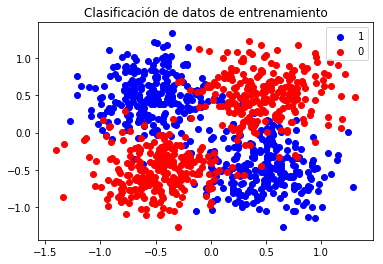

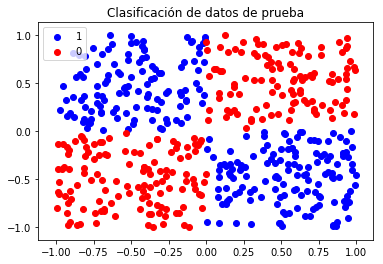

In [7]:
import matplotlib.pyplot as plt

Trues_train = X_train[np.where(Y_train)]
Falses_train = X_train[np.where(np.logical_not(Y_train))]
plt.title("Clasificación de datos de entrenamiento")
plt.scatter(Trues_train[:,0],Trues_train[:,1],color = "blue",label = "1")
plt.scatter(Falses_train[:,0],Falses_train[:,1],color = "red", label = "0")
plt.legend()
plt.show()

Trues_test = X_test[np.where(Y_test)]
Falses_test = X_test[np.where(np.logical_not(Y_test))]
plt.title("Clasificación de datos de prueba")
plt.scatter(Trues_test[:,0],Trues_test[:,1],color = "blue",label = "1")
plt.scatter(Falses_test[:,0],Falses_test[:,1], color = "red",label = "0")
plt.legend()
plt.show()

Se puede apreciar a primera vista que los fronteras no son lineales, además en los datos de entrenamiento se pueden ver algunos puntos "mal clasificados", es decir, hay puntos rojos en las zonas de los azules y viceversa, esto se debe probablemente al ruido de los datos de entrenamiento a diferencia de los datos de prueba.

> b) Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Comente cualitativamente lo que observa.
```python
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()
model.fit(X,y)
visualize_border(model,X,y,"LDA")
```

C:\Users\Palomo\Anaconda3\envs\py36\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


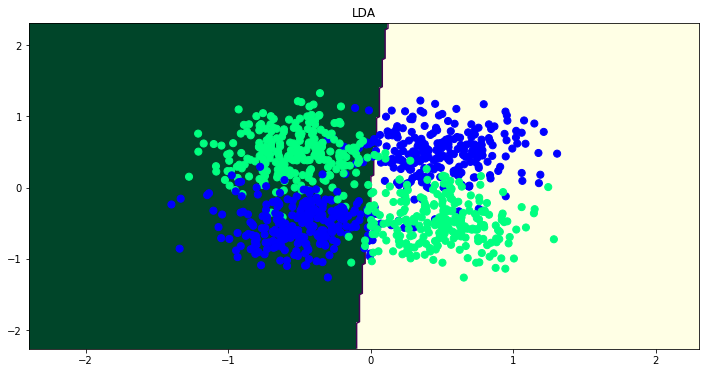

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def visualize_border(model,x,y,title=""):
    fig, axis = plt.subplots(1, 1,figsize=(12, 6))

    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #or predict_proba
    Z = Z.reshape(xx.shape)
    Zplot = Z > 0.5
    
    axis.scatter(x[:,0],x[:,1],s=50,c=y,zorder=10,cmap=plt.cm.winter)
    axis.contour(xx, yy, Z,levels=[-1, 0, 1])
    axis.pcolormesh(xx, yy, Zplot ,cmap=plt.cm.YlGn)
    plt.title(title)
    plt.show()
    

model = LDA()
model.fit(X_train,Y_train)
visualize_border(model,X_train,Y_train,"LDA")

Como era de esperarse, una frontera lineal como la que genera LDA no puede separar adecuadamente los datos debido a que no son linealmente separables.

> c) Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué  distribución de probabilidad asumen cada uno?
```python
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA()
model.fit(X,y)
```

C:\Users\Palomo\Anaconda3\envs\py36\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


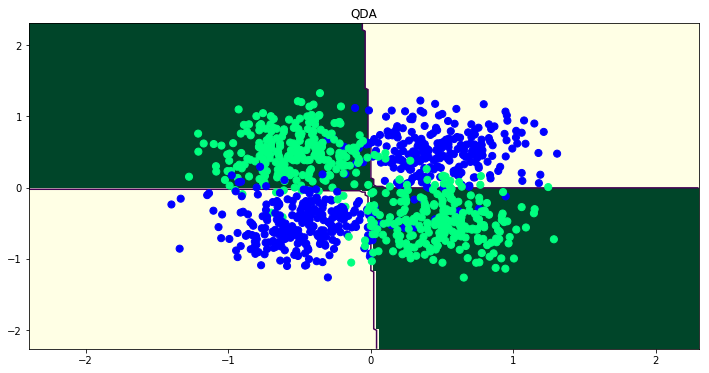

In [5]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA()
model.fit(X_train,Y_train)
visualize_border(model,X_train,Y_train,"QDA")

QDA logra obtener una mejor separación entre las clases con respecto a LDA, esto debido a que QDA no necesariamente creará fronteras lineales. Ambos asumen una distribución de probabilidad normal, la diferencia es que LDA, en su cálculo de la distribución de probabilidad, obtiene medias diferentes para cada clase pero la misma varianza para todas las clases, lo que resulta en una matriz de covarianza única para todas las clases; en cambio QDA asume medias y varianzas diferentes para cada clase, causando matrices de covarianza diferentes, lo que finalmente resulta en fronteras no lineales.

Para lo que sigue de la actividad se trabajará con una widget interactiva [[2]](#refs) para sintonizar los parámetros de regularización o estructurales de los distintos algoritmos. Por ello cada vez que se modifique el parámetro en la ventana se entrenará el modelo y se visualizará la frontera en la misma imagen.
```python
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X..,y..) #here choose train/test or both!
```

> d) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) Lineal no puede resolver el problema, para esto construyala a través de *sklearn*. Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$. Analice cualitativamente lo observado, para validar su análisis cualitativo calcule el *accuracy* sobre el conjunto de pruebas.
```python
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='linear')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -6 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))
```

In [9]:
from sklearn.svm import SVC as SVM #SVC is for classification
from sklearn.metrics import accuracy_score
from ipywidgets import interactive

#train datasets:
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X_train,Y_train)
    
def visualize_border_interactive_test(param):
    model = test_model_SVM(param)
    visualize_border(model,X_test,Y_test) 

def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='linear')
    model.fit(X_train,Y_train)
    print("Train Accuracy: ",model.score(X_train,Y_train))
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model

def test_model_SVM(param):
    model= SVM()
    C = 10**(param)
    model.set_params(C=C,kernel='linear')
    model.fit(X_train,Y_train)
    print("Train Accuracy: ",accuracy_score(Y_train,model.predict(X_train)))
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model

p_min = -4 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=0, description='param', max=4, min=-4), Output()), _dom_classes=('widget…

In [24]:
interactive(visualize_border_interactive_test,param=(p_min,p_max))

interactive(children=(IntSlider(value=0, description='param', max=4, min=-4), Output()), _dom_classes=('widget…

Al variar el parametro de regularización C, se tiene lo esperado, una frontera lineal no puede resolver adecuadamente el problema, de hecho al ir variando el parámetro C se obtiene que el score pareciera converger a 0.5 (0.486 fue el valor más alto obtenido para el rango elegido en C = 0.1), que es la probabilidad de elegir una clase aleatoriamente para este caso de dos clases. Para valores bajos de C, el accuracy disminuye convergiendo a 4.66 aproximadamente. Un analisis similar ocurre en el dataset de prueba.

> e) Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) no Lineal puede resolver el problema, para ésto construya una SVM no Lineal a través de un **kernel** [[3]](#refs). Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$ y con diferentes kernels. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.
```python
...#edit the train_model function
model.set_params(C=C,kernel='rbf') #try poly
```

In [10]:
def visualize_border_interactive2(param,kernel):
    model = train_model2(param,kernel)
    visualize_border(model,X_train,Y_train) #here choose train/test or both!
    
def train_model2(param,kernel):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel=kernel)
    model.fit(X_train,Y_train)
    print("Train Accuracy: ",model.score(X_train,Y_train))
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -4 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive2,param=(p_min,p_max),kernel = ['rbf','poly','sigmoid'])

interactive(children=(IntSlider(value=0, description='param', max=4, min=-4), Dropdown(description='kernel', o…

La función SVC utilizada acepta diversos tipos de kernels,

> f) Demuestre experimentalmente que un Árbol de Decisión de múltiples niveles puede resolver el problema ¿Qué pasa con un nivel? Para ésto contruya el Árbol de Decisión a través de *sklearn*, puede utilizar el criterio y la función de partición que prefiera. Mediante la *widget* interactiva explore diferentes valores del parámetro de máxima profundidad del árbol. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.
```python
from sklearn.tree import DecisionTreeClassifier as Tree
model = Tree() #edit the train_model function
model.set_params(max_depth=param,criterion='gini',splitter='best')
...#here param=depth
p_min = 1 #define your range
p_max = 40 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))
```

El parámetro dado dicta la profundidad del arbol, es decir la cantidad de reglas que tomará en consideración antes de clasificar, por lo tanto, cuando el parámetro valga 1, solo se tendra una regla de decisión en base a los atributos, lo que probablemente de un mal error de clasificación, luego al aumentar el parámetro, al tener más reglas debiese ocurrir que el error de clasificación disminuya, pero aumenta el riesgo de sobre ajuste.

In [11]:
from sklearn.tree import DecisionTreeClassifier as Tree
def visualize_border_interactive3(param):
    model = train_model3(param)
    visualize_border(model,X_train,Y_train)

def train_model3(param):
    model= Tree()
    C = param
    print("Param C= ",C)
    model.set_params(max_depth=C,criterion='gini',splitter='best')
    model.fit(X_train,Y_train)
    print("Train Accuracy: ",model.score(X_train,Y_train))
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model    

p_min = 1 #define your range
p_max = 100 #define your range
interactive(visualize_border_interactive3,param=(p_min,p_max))

interactive(children=(IntSlider(value=50, description='param', min=1), Output()), _dom_classes=('widget-intera…

Al observar los gráficos obtenidos, se obtiene el bajo valor de clasificación esperado para un valor de profundidad igual a 1, de hecho se muestra una frontera lineal con un score igual a 0.478, al aumentar la profundida del arbol el score aumenta, pero el mayor valor obtenido ocurre para una profundidad igual a 3, con un score de 0.97, pasado a eso la precisión disminuye.

> g) Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema. Para esto construya un perceptrón multi-capa, con una capa escondida, variando el número de neuronas $N_h$ a través de la *widget* interactiva. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.
```python
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    return model
p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))
```

El parámetro dicta la cantidad de neuronas que tendra la capa escondida, esta capa aplica una función extra a las neuronas antes de que la segunda capa (función de salida) termine la clasificación, entonces si se usa una mayor cantidad de neuronas en la capa escondida, se deberían obtener mejores resultados.

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Train Accuracy: ",model.evaluate(X_train, Y_train,batch_size=128,verbose=0)[1])
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    return model

p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

C:\Users\Palomo\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


interactive(children=(IntSlider(value=5, description='param', max=10), Output()), _dom_classes=('widget-intera…

Al probar valores de neuronas lo primero que se nota es que el score obtenido no es determinista, pero pareciera haber una tendencia a aumentar el accuracy a medida que aumenta el número de neuronas, con valores muy cercanos a 1.

> h) Construya un algoritmo $k$-NN para la clasificación del problema. Mediante la *widget* interactiva explore diferentes valores del parámetro $k$. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.
```python
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.set_params(n_neighbors=param)
```

In [43]:
from sklearn.neighbors import KNeighborsClassifier

def train_model(param):
    neighbors = param
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=neighbors)
    print("Neighbors = ", neighbors)
    model.fit(X_train,Y_train)
    print("Train Accuracy: ",model.score(X_train,Y_train))
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model    

p_min = 1 #define your range
p_max = 1000 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=500, description='param', max=999, min=1), Output()), _dom_classes=('wid…

Lo que hace este clasificador es ver los k vecinos mas cercanos a un dato, luego le asigna una clase al dato en base a la clase mas presente en dichos vecinos, entonces el parametro k dira la cantidad de vecinos a mirar para asignar la clase, se podría pensar que ver una mayor cantidad de vecinos aumente la precisión, pero al aumentar mucho dicho valor se obtiene experimentalmente que la precisión disminuye, finalmente al igualar la cantidad de vecinos al total de datos el clasificador no puede clasificar correctamente obviamente debido a que debe ver n vecinos cuando son n-1 vecinos en total. 

> i) Vuelva a generar datos, pero ahora de manera desbalanceada por clase, con más ejemplos en una clase que en otra, pero manteniendo el conjunto de pruebas para verificación. Visualicelo apropiadamente.
```python
X_train,Y_train,X_test,Y_test = do_gaussianXOR(n1=250,n2=5)
```

(510, 2)
(510,)
(255, 2)
(255,)


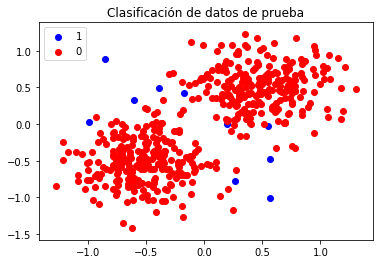

Cantidad de 1: 10
Cantidad de 0: 500


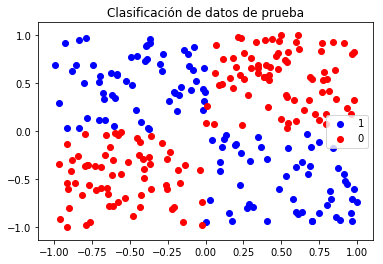

Cantidad de 1: 113
Cantidad de 0: 142


In [66]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR(n1=250,n2=5)

print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))

Trues_train = X_train[np.where(Y_train)]
Falses_train = X_train[np.where(np.logical_not(Y_train))]
plt.title("Clasificación de datos de prueba")
plt.scatter(Trues_train[:,0],Trues_train[:,1],color = "blue",label = "1")
plt.scatter(Falses_train[:,0],Falses_train[:,1], color = "red",label = "0")
plt.legend()
plt.show()

print("Cantidad de 1: " + str(len(Trues_train)))
print("Cantidad de 0: " + str(len(Falses_train)))

Trues_test = X_test[np.where(Y_test)]
Falses_test = X_test[np.where(np.logical_not(Y_test))]
plt.title("Clasificación de datos de prueba")
plt.scatter(Trues_test[:,0],Trues_test[:,1],color = "blue",label = "1")
plt.scatter(Falses_test[:,0],Falses_test[:,1], color = "red",label = "0")
plt.legend()
plt.show()

print("Cantidad de 1: " + str(len(Trues_test)))
print("Cantidad de 0: " + str(len(Falses_test)))

> j) Escoga las Máquinas de Soporte Vectorial con kernel RBF ($C=1$) o un Árbol de Decisión ($depth=5$) para entrenar sobre estos datos desbalanceados, mida el *Accuracy* sobre el conjunto de pruebas.

In [69]:
modelSVM= SVM()
modelSVM.set_params(kernel='rbf')
modelSVM.fit(X_train,Y_train)
print("Accuracies SVM:")
print("Train Accuracy: ",modelSVM.score(X_train,Y_train))
print("Test Accuracy: ",modelSVM.score(X_test,Y_test))
print("\n")

modelTree= Tree()
modelTree.set_params(max_depth = 5,criterion='gini',splitter='best')
modelTree.fit(X_train,Y_train)
print("Accuracies Decision Tree:")
print("Train Accuracy: ",modelTree.score(X_train,Y_train))
print("Test Accuracy: ",modelTree.score(X_test,Y_test))


Accuracies SVM:
Train Accuracy:  0.9803921568627451
Test Accuracy:  0.5568627450980392


Accuracies Decision Tree:
Train Accuracy:  0.9882352941176471
Test Accuracy:  0.5686274509803921


El desbalanceo en los datos provoca un claro overfitting al comparar la accuracy de entrenamiento con la de pruebas.

> k) Ahora verifique que se puede mejorar la métrica a través de poner un peso en la función objetivo para las distintas clases, *seteelo* a mano o utilize la función *balanced* para que reduzca el impacto de lo datos de la clase mayoritaria en la función objetivo o que aumente el impacto de los datos de la clase minoritaria.
```python
classes_weights = {0: 0.1, 1: 10} #or choose..
model.set_params(C=1,kernel='rbf',class_weight=classes_weights or 'balanced') #for svm
model.set_params(max_depth=5,criterion='gini',splitter='best',class_weight=classes_weights or 'balanced') #for decision tree
model.fit(X_train,Y_train)
model.score(X_test,Y_test)
```

In [91]:
#Balanced

print("Balanced:")
modelSVM.set_params(C=1,kernel='rbf',class_weight='balanced') #for svm
modelSVM.fit(X_train,Y_train)
print("Using SVM: " + str(modelSVM.score(X_test,Y_test)))

modelTree.set_params(max_depth=5,criterion='gini',splitter='best',class_weight='balanced') #for decision tree
modelTree.fit(X_train,Y_train)
print("Using Desicion Tree: " + str(modelTree.score(X_test,Y_test)) + '\n')

#Class weights
def class_weights(clase_0,clase_1):
    classes_weights = {0: clase_0, 1: clase_1} #or choose..
    print("Class weights:")
    modelSVM.set_params(C=1,kernel='rbf',class_weight=classes_weights) #for svm
    modelSVM.fit(X_train,Y_train)
    print("Using SVM: " + str(modelSVM.score(X_test,Y_test)))
    modelTree.set_params(max_depth=5,criterion='gini',splitter='best',class_weight=classes_weights) #for decision tree
    modelTree.fit(X_train,Y_train)
    print("Using Desicion Tree: " + str(modelTree.score(X_test,Y_test)))
    return

c0_min = 1
c0_max = 100
c1_min = 1
c1_max = 100
interactive(class_weights,clase_0=(c0_min,c0_max),clase_1 = (c1_min,c1_max))



Balanced:
Using SVM: 0.8980392156862745
Using Desicion Tree: 0.7450980392156863



interactive(children=(IntSlider(value=50, description='clase_0', min=1), IntSlider(value=50, description='clas…

Al utilizar el metodo 'balanced' para asignar los pesos a las clases (asignar un peso inversamente proporcional a la frecuencia de la clase) se mejora notablemente el accuracy, ahora al asignar pesos manualmente, se obtiene, como era de esperarse, que disminuir el peso de la clase menos frecuente (en comparación a la más frecuente) empeora los resultados, al probar el caso contrario, es decir aumentar el peso de la clase menos frecuente en comparación a la clase más frecuente, hay combinaciones que obtienen mejores resultados que utilizar los pesos 'balanced'.

## Pregunta 2:

> a) Cargue los datos del *output* del modelo (*labels*), descríbalos ¿Cuántos ejemplos hay por cada clase?
```python
import pandas as pd
import numpy as np
y = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None).values
y.shape
```

In [3]:
import pandas as pd
import numpy as np
y = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s",header=None,engine='python').values
label_names = np.loadtxt("Concepts81.txt",dtype='object')
print(y.shape)
print("Ejemplos por clase:\n")
for i in range(81):
    print(label_names[i] + ': ' + str(np.sum(y[...,i]==1)))


(27807, 81)
Ejemplos por clase:

airport: 342
animal: 2968
beach: 2097
bear: 68
birds: 471
boats: 1551
book: 11
bridge: 717
buildings: 4652
cars: 348
castle: 172
cat: 113
cityscape: 830
clouds: 15538
computer: 27
coral: 363
cow: 199
dancing: 44
dog: 237
earthquake: 8
elk: 116
fire: 151
fish: 346
flags: 40
flowers: 615
food: 70
fox: 58
frost: 247
garden: 802
glacier: 187
grass: 4933
harbor: 243
horses: 322
house: 1398
lake: 5758
leaf: 153
map: 3
military: 726
moon: 240
mountain: 2098
nighttime: 1031
ocean: 4659
person: 3329
plane: 693
plants: 2717
police: 203
protest: 60
railroad: 232
rainbow: 128
reflection: 3235
road: 2031
rocks: 2054
running: 99
sand: 549
sign: 97
sky: 19052
snow: 1275
soccer: 29
sports: 245
statue: 94
street: 557
sun: 1529
sunset: 3320
surf: 79
swimmers: 90
tattoo: 18
temple: 294
tiger: 48
tower: 667
town: 774
toy: 140
train: 230
tree: 1340
valley: 1682
vehicle: 1522
water: 11019
waterfall: 122
wedding: 144
whales: 132
window: 2660
zebra: 20


Hay 27807 instancias de 81 atributos, los valores anteriores corresponden a cuantos ejemplos contienen dicha clase, se puede notar que hay mucha cantidad de algunos en comparación a otros.

> b) Visualice el tema de que un dato  (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema *multi-label* y cómo aplica en este caso.
```python
import urllib2,re
label_names = np.loadtxt("ConceptsList/Concepts81.txt",dtype='object')
arch = open("NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()
"""Visualizacion"""
from PIL import Image
s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(y[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urllib2.urlopen(data_urls[s]))
im
```

Etiquetas de la imagen : ['buildings' 'clouds' 'person' 'road' 'sky' 'street' 'window']


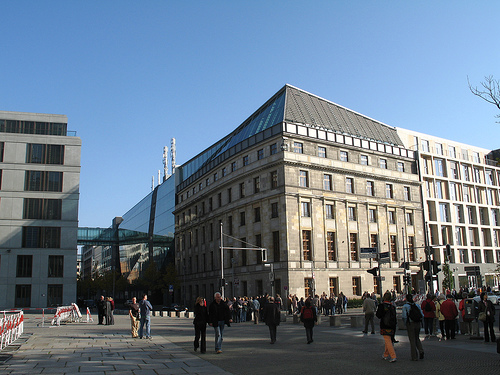

In [54]:
import urllib.request,re
arch = open("NUS-WIDE-urls.txt",'r') #lectura para mapeo de link a url
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()
"""Visualizacion"""
from PIL import Image
s = np.random.randint(0,len(data_urls)) #mostrar para una imagen random
category_sample = np.where(y[s]==1)[0] 
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urllib.request.urlopen(data_urls[s]))
im

El problema multi label es un problema de clasificación en el que una instancia puede tener multiples clases asignadas a la vez,  en este caso la idea es identificar objetos o temas que aparecen en la imagen, por ejemplo si hay montañas, edificios, cielo, entre otras, es claro que se pueden encontrar varios de estos objetos/temas en cada imagen.

> c) Comente sobre la **representación** que posee la salida de los modelos (*labels*) ¿En qué dominio habita? ¿Tiene restricciones?

Al ser un problema multi label, la salida no solo sera una lista de un único 1 y varios ceros, sino que ahora sera una combinación de unos y ceros, complicando en gran medida el problema, dado que en un principio solo se tienen 81 posibles outputs, ahora se tienen $2^{81} outputs posibles, pero al ver los labels se puede ver que hay algunos labels que no pueden estar juntos y otros que deben estarlo, por ejemplo los labels "nighttime" y "sun" no deberían encontrarse juntos, mientras que las clases "lake" o "waterfall" deberían ir con la clase "water". Esto reduce en alguna medida el dominio del output.

> d) Decida sobre una **representación**, en este caso descriptores, para la entrada a los modelos (*input*), puede utilizar la mezcla entre distintos descriptores, comente sobre la elección y qué representa.
```python
file = "Normalized_CH_Lite_Train.dat" or "Normalized_CM55_Lite_Train.dat"
descriptors = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s",header=None).values
descriptors.shape
```
*Recuerde que siempre puede optar por muestrear y así achicar los datos de entrenamiento por temas de cómputo*

In [69]:
file = "Normalized_CM55_Lite_Train.dat"
descriptors = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s",header=None,engine = "python").values
print(descriptors.shape)
print(descriptors[0])

file2 = "Normalized_CH_Lite_Train.dat" 
descriptors2 = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file2,delimiter="\s",header=None,engine = "python").values
print(descriptors2.shape)
print(descriptors2[0])

(27807, 225)
[ 0.177545 -0.084588 -0.300361 -0.119638 -0.113919  0.159027 -0.143603
 -0.161493 -0.135176  0.246798 -0.258361 -0.119362 -0.047804 -0.062693
  0.084641 -0.103801 -0.132584  0.227475  0.199286 -0.12399  -0.166269
  0.20127  -0.016571 -0.184839  0.098759 -0.075149 -0.108321  0.077775
  0.001084 -0.257213  0.093128  0.173786 -0.273731 -0.072936  0.176965
 -0.359859 -0.085163  0.075707 -0.243995 -0.112819  0.242304  0.384603
 -0.315928  0.291974 -0.626111 -0.232356  0.513898 -0.46385   0.036089
  0.208115  0.257833 -0.104554  0.368657 -0.579669  0.242258 -0.216932
 -0.124544  0.062746  0.000945  0.06051  -0.011163 -0.106217  0.185759
  0.296887 -0.366409 -0.070723  0.093233 -0.212304 -0.02936  -0.001333
 -0.236743 -0.034466 -0.161763  0.025291 -0.305736 -0.012328 -0.01259
 -0.319833 -0.216131  0.320214 -0.662919 -0.07749  -0.009122 -0.045505
 -0.364589  0.039983  0.304479 -0.666427  0.095986 -0.583794  0.270293
 -0.417556  0.071144 -0.191831 -0.303817 -0.106283 -0.145554 -0.3

Normalized CH es histograma de colores de 64 dimensiones, este se usa para obtener la distribución de colores general de una imagen, mientras que Normalized CM55 muestra los momentos de los colores de 255 dimensiones, este se usa para tener una idea de en que posición estan los colores, lo ideal sería usar ambos para obtener la mayor cantidad de información en cuanto al color y posición, pero si resulta muy costoso computacionalmente, se optaría por utilizar los momentos, dado que estos contienen información de posiciones que el histograma de colores no entrega.

> e) Deje un conjunto separado para evaluar los modelos y comportar como conjunto de pruebas, además de realizar la clásica estandarización de las entradas de los modelos.
```python
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)
```

In [73]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)
print("Dimensiones conjunto de entrenamiento:" + str(X_train.shape))
print("Dimensiones conjunto de Pruebas:" + str(X_test.shape))

Dimensiones conjunto de entrenamiento:(18630, 225)
Dimensiones conjunto de Pruebas:(9177, 225)


> f) Se presenta una métrica para validar en el código a continuación, la cual mide la cantidad de aciertos a las *labels* que tenga un dato de manera normalizada. Defina **otra** métrica a utilizar con el propósito de validar lo mismo (el desempeño de un modelo).
```python
def evaluation_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.dot(y,yp) / np.sum(y)  #cantidad de valores iguales
    return suma/float(len(y_true))
...#define another!!
```

In [78]:
def evaluation_metric(y_true,y_pred): 
    suma = 0
    ceros = 0
    for y,yp in zip(y_true,y_pred):
        suma += np.dot(y,yp) / np.sum(y)  #cantidad de valores iguales
    return suma/float(len(y_true))

def my_evualtion_metric(y_true,y_pred):
    suma = 0
    for y,yp in zip(y_true,y_pred):
        if (y_true == y_pred):
            suma += 1
    return suma/float(len(y_true))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


> g) Experimente en resolver el problema con un Árbol de Decisión (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender de manera sencilla a *multi-label* [[4]](#refs). Mida las métricas de desempeño definidas anteriormente sobre ambos conjuntos (entrenamiento y pruebas), comente.
```python
from sklearn.tree import DecisionTreeClassifier as Tree
model = Tree() 
model.set_params(max_depth=?,criterion=?,splitter=?)
model.fit(X_train,y_train)
```
Para realizar las predicciones y evaluar utilice:
```python
y_pred = model.predict(X_test)
evaluation_metric(y_test,y_pred)
```

> h) Experimente en resolver el problema con una Máquina de Soporte Vectorial no lineal (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender a *multi-label* a través de la técnica **OneVsRest**. Mida las métricas de desempeño al igual que para el Árbol de Decisión, comente y compare sobre las métricas y los tiempos de ejecución.
```python
from sklearn.svm import SVC as SVM #SVC is for classification
from sklearn.multiclass import OneVsRestClassifier
model= SVM()
model.set_params(C=?,kernel='rbf')
meta_model = OneVsRestClassifier(model)
meta_model.fit(X_train,y_train)
```

> i) Experimente en resolver el problema con una Red Neuronal *Feed Forward* (decida el número de capas y el número de neuronas, si desea puede utilizar las por defecto). Éste modelo se extiende a *multi-label* a través de la interfaz de *keras* seleccionando una *loss* adecuada, en este caso **binary cross entropy** ¿Por qué?
```python
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy")
model.fit(X_train, y_train, epochs=40, batch_size=128, verbose=1)
```

> j)  Realice predicciones **probabilísticas** de su modelo ¿Las probabilidades están normalizadas? ¿Por qué? Además defina una forma para pasar de la representación de las probabilidades a la representación de *labels* categoricos definidos como en c).  
*Hint: Recuerde que el no pertenecer a ninguna *label*/etiqueta es una posibilidad!!*
```python
prob_pred = model.predict(X_test) 
y_pred = transform(prob_pred) #define a translate
```

> k) Ahora que recuperó la representación de las *labels* mida las métricas de desempeño sobre la Red Neuronal. Compare y comente.

<a id="tercero"></a>

## 3. *Taxi Trip Duration*: Predicción de duración de viaje

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Newyorkcity_taxi_motion_banner.jpg" />


En esta actividad trabajaremos con un dataset de una competencia en la plataforma Kaggle, el cual se llama **New York City Taxi Trip Duration** y que puede ser accedido a través del siguiente __[link](https://www.kaggle.com/c/nyc-taxi-trip-duration/)__. Como se puede ver es una competencia para predecir la duración del viaje de un taxi en Nueva York, por lo que es un problema de regresión que resulta altamente no lineal  y no determinista debido a las invariantes que tiene, por ejemplo un viaje de un punto a otro puede durar distinto tiempo dependiendo de múltiples factores, como el horario, la congestión de ese día u otros.

La métrica de evaluación de la competencia y la que utlizaremos será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

O en código Python:
```python
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))
```


Descarge los datos de la competencia, únicamente trabajaremos con el archivo *train.zip* o *train.csv*, ya que no conocemos los valores reales del conjunto *test*, tendrémos que simularlo.

## Pregunta 3:

In [1]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.
```python
import pandas as pd
df = pd.read_csv("train.csv")
df.info()
df.head()
output = df['trip_duration'].values
```

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("train.csv")
df.info()
df.head()
output = df['trip_duration'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Son 11 atributos, los atributos en general son bastante evidentes, a excepción del atributo store_and_fwd_flag, este es un atributo binario que dice si el registro del viaje se guardo en la memoria del vehiculo antes de ser enviada al vendedor debido a que el vehiculo no tenia conexión con el servidor, Y significa que si ocurrio lo anterior, N que no.

In [2]:
df["store_and_fwd_flag"].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

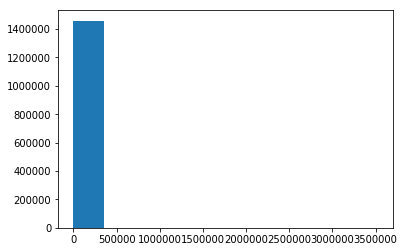

In [91]:
plt.hist(output)
plt.show()

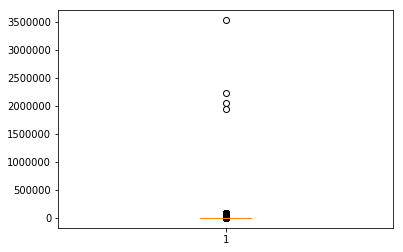

In [3]:
plt.boxplot(output)
plt.show()

El boxplot muestra la cantidad de outliers, parecieran ser 4 a primera vista.

> b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.
```python
eliminar outliers
df = df[(df['trip_duration']<=100000)]
```

In [6]:
print(df.shape)
df = df[(df['trip_duration']<=100000)]
print(df.shape)

(1458640, 11)
(1458640, 11)


Se eliminaron 4 registros.

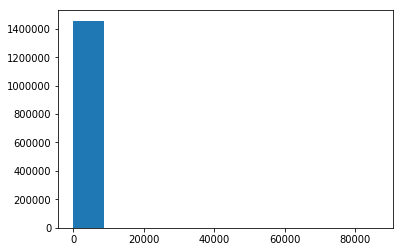

In [95]:
output = df['trip_duration'].values
plt.hist(output)
plt.show()

Al quitar los outliers se ve que la mayor cantidad de viajes no pasa los 10000 segundos (aprox 4 horas), entonces para entender mejor la distribucion de datos se hará un histograma con los datos de duraciones de hasta 10000 segundos:

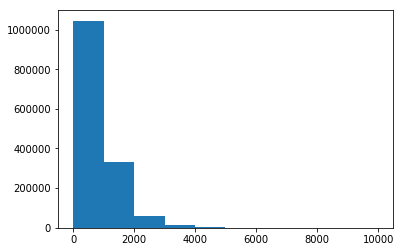

In [7]:
output = df[df["trip_duration"].values < 10000]["trip_duration"].values
plt.hist(output)
plt.show()

Parece que la mayor concentracion de datos esta en valores entre 0 y 4000, se vizualizarán estos datos ahora:

1450346


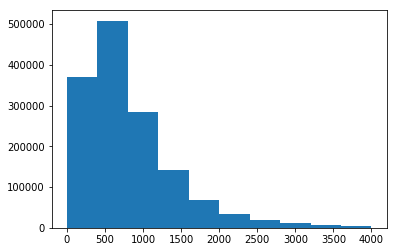

In [19]:
output = df[df["trip_duration"].values < 4000]["trip_duration"].values
print(len(output))
plt.hist(output)
plt.show()

Pareciera ser que la distribución de los datos sigue una distribución normal de probabilidad.

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hcaer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.  
```python
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()
```
<div class="alert alert-info"> *Si el proceso demora mucho, lo que se aconseja es realizarlo una vez, guardar los datos en disco y luego leerlos cada vez que se experimenta con los códigos para las pruebas de los modelos de aprendizaje* </div>

In [7]:
from geopy.distance import great_circle
import numpy as np
#extraer caract geograficas
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all

def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360

from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')

def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


In [8]:
#guardar el nuevo dataframe
df.to_csv("trainV2.csv", index=False)

El preprocesamiento hace una serie de cambios al dataset:  
- Crea las siguientes columnas nuevas: hour, cday, month, distancia_viaje, distancia_viaje_km, grado_direccion, season y holiday.
- hour: hora del "pickup" del pasajero.
- cday: dia del "pickup" del pasajero (mapeado a 0:Lunes, ..., 6:Domingo).
- month: mes del "pickup" del pasajero (mapeado a 1:Enero, ..., 12:diciembre).
- distancia_viaje: distancia euclidiana del viaje.
- distancia_viaje_km: distancia basada en la funcion great_circle en km.
- grado_direccion: dirección en grados.
- season: estaciones del año, en este caso solo tomará 3 valores: winter (invierno), spring (primavera), summer (verano), estos estan mapeados a 0,1 y 2 respectivamente.
- holiday: dice si el día es festivo o no (vale 0 o 1).
- Elimina las siguientes columnas del dataset: pickup_datetime, dropoff_datetime (estas dos se representaron con las columnas agregadas), id, vendor_id, store_and_fw_flag.  

Entonces finalmente quedan 14 atributos.

In [3]:
#cargar datos del nuevo dataframe
df = pd.read_csv("trainV2.csv")

> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.
```python    
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

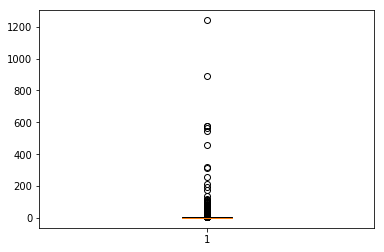

In [5]:
plt.boxplot(df["distancia_viaje_km"].values)
plt.show()

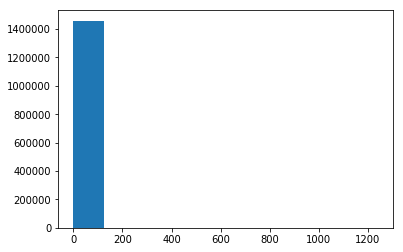

In [6]:
plt.hist(df["distancia_viaje_km"].values)
plt.show()

Al realizar nuevamente un boxplot se puede ver que aún hay una alta presencia de outliers en el atributo de las distancias de viaje, por lo tanto se utilizará el RobustScaler, que no es influenciado por la cantidad de outliers.

In [7]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
#scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[0]

array([ 0.        , -0.01555694,  0.78895075, -0.26443605,  0.63649635,
        0.2       , -0.75      , -1.        , -0.6012209 , -0.59859099,
        0.38510372, -1.        ,  0.        ])

> e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.
```python
model = choose #SVM, Decision Trees or Neural Network
model.fit(X_train_scaled,y_train)
print "ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train)
print "ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test)
```

Según lo experimentado en la sección 1, una red neuronal pareciera ser la que entrega la mejor precisión, por lo que se usará esta, sin embargo, no hay que olvidar que el problema en la pregunta 1 era un problema de clasificación, este es un problema de regresiòn, por lo tanto puede que no funcione con tanta precisión, además otro factor a considerar es que ahora hay una mayor cantidad de atributos y el dataset es mucho más grande.

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(4, input_dim=13, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train_scaled,y_train)
print("ERROR RMSLE de training: " + str(rmsle(model.predict(X_train_scaled),y_train)))
print("ERROR RMSLE de test: " + str(rmsle(model.predict(X_test_scaled),y_test)))

Epoch 1/1
1021048/1021048 [==============================] - 34s 33us/step - loss: 10083355.5953
ERROR RMSLE de training: [0.76752655]
ERROR RMSLE de test: [0.76930043]


La red neuronal utilizada entrega un error significativo, por lo tanto se probará con un support vector machine y finalmente con un arbol de clasificación para regresión, en la pregunta 1 este fue el orden de las precisiones de clasificadores (primero red neuronal, luego SVM y finalmente decisión tree).  
Entonces ahora se revisará el error que entrega una support vector machine para regressión, mejor conocida como support vector regression:

In [ ]:
#no termina de compilar, aun con kernel lineal...
from sklearn.svm import SVR

model = SVR()
model.fit(X_train_scaled,y_train)
print("ERROR RMSLE de training: " + str(rmsle(model.predict(X_train_scaled),y_train)))
print("ERROR RMSLE de test: " + str(rmsle(model.predict(X_test_scaled),y_test)))

Usar una SVR con parámetros que entrega por defecto causa que la ejecución no termine, esto debido a que las SVM necesitan calcular distancias entre cada punto de los dataset, lo que puede resultar muy costoso, sin embargo variando algunos parámetros de la SVR tal vez se podría entrenar en un tiempo decente.  
Ahora se probará usar un decision tree para regresión:

In [48]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train_scaled,y_train)
print("ERROR RMSLE de training: " + str(rmsle(model.predict(X_train_scaled),y_train)))
print("ERROR RMSLE de test: " + str(rmsle(model.predict(X_test_scaled),y_test)))

ERROR RMSLE de training: 0.0
ERROR RMSLE de test: 0.504499430924974


El decision tree entrega menor error RMSLE que la red neuronal, por lo tanto se elegirá este, a pesar de que tenga un notable overfitting, pero se espera que variando parámetros se solucione este problema, además no olvidar que todo lo obtenido fue usando parámetros por defecto, por lo que variando estos tal vez otro learner podría superar al decision tree. 

> f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?
```python
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
graficar_predicciones(y_test,model.predict(X_test_scaled))
```

Se esperan grandes diferencias debido al error obtenido.

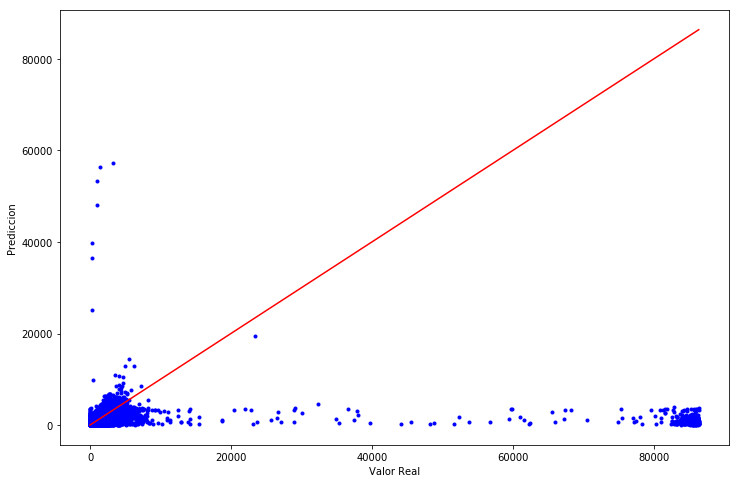

In [11]:
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
graficar_predicciones(y_test,model.predict(X_test_scaled))

Para valores cercanos a 0, se obtiene que las predicciones se parecen más a los valores reales, pareceria haber una tendencia del clasificador a generar duraciones pequeñas para viajes de taxis, lo que en general tiene sentido para viajes de taxis, pero el dataset dice que hay varios viajes de taxis que duran más de 80000 segundos, lo que equivale a aproximadamente 22 horas, esto pareciera ser un viaje muy largo para un taxi, no es imposible pero es sospechoso.

> g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 

Dada la gran cantidad de datos, se utilizará un test de validación que corresponde al 20% de datos del antiguo set de entrenamiento:

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(816838, 14)
(816838,)
(204210, 14)
(204210,)
(437592, 14)
(437592,)


In [7]:
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [38]:
model = DecisionTreeRegressor()
model.fit(X_train_scaled,y_train)
print("ERROR RMSLE de training: " + str(rmsle(model.predict(X_train_scaled),y_train)))
print("ERROR RMSLE de validation: " + str(rmsle(model.predict(X_val_scaled),y_val)))
print("ERROR RMSLE de test: " + str(rmsle(model.predict(X_test_scaled),y_test)))

ERROR RMSLE de training: 0.0
ERROR RMSLE de validation: 0.5801143762858172
ERROR RMSLE de test: 0.5853609148503138


In [40]:
from ipywidgets import interactive
def interactive_Tree(depth,split):
    model = DecisionTreeRegressor(max_depth = depth, min_samples_split = split)
    model.fit(X_train_scaled,y_train)
    print("ERROR RMSLE de training: " + str(rmsle(model.predict(X_train_scaled),y_train)))
    print("ERROR RMSLE de validation: " + str(rmsle(model.predict(X_val_scaled),y_val)))

d_min = 1
d_max = 30
s_min = 2
s_max = 30
interactive(interactive_Tree,depth=(d_min,d_max),split=(s_min,s_max))

interactive(children=(IntSlider(value=15, description='depth', max=30, min=1), IntSlider(value=16, description…

Configuraciónes que mejoran el error de validación anterior:  
depth = 7, split = 7, error = 0.5757227056761175.  
depth = 8, split = 10, error = 0.5733528572784785.  
depth = 9, split = 10, error = 0.5662760094060023.  
depth = 10, split = 10, error = 0.5592468780351031.  
depth = 10, split = 11, error = 0.5596777842157972.  
depth = 11, split = 10, error = 0.5558937497786492.  
depth = 20, split = 10, error = 0.523809386982788. (posible overfit: ERROR RMSLE de training: 0.4318234132963307)  
depth = 15, split = 16, error = 0.5434883997005211.  
  
Al probar una serie de valores se obtiene que el mejor error de validación lo entrega la combinación de parámetros depth = 20 y split = 10, sin embargo, valores de alto depth en comparación al split suelen entregar errores bajos de entrenamiento en comparación a los de validación, por lo tanto se optará por usar la combinación de parámetros depth = 15 y split = 16, dado que reducen en mayor medida el error de validación con menos riesgo de overfit (aumentar ambos valores en gran medida genera overfit también).

In [9]:
model = DecisionTreeRegressor(max_depth = 15, min_samples_split = 16)
model.fit(X_train_scaled,y_train)
print("ERROR RMSLE de test: " + str(rmsle(model.predict(X_test_scaled),y_test)))

ERROR RMSLE de test: 0.5449925713912745


> h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering* [[6]](#refs). Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).

Primero se quitaran algunos datos que no son posibles en base al contexto del problema, primero los que su duracion sea mayor a 22 horas, esto es en base al lugar donde ocurre la mayoría de los viajes: entre Manhattan y NYC ( https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious ):

In [12]:
from sklearn.tree import DecisionTreeRegressor
df2 = pd.read_csv("trainV2.csv")
print(df2.columns.values)

['passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'trip_duration' 'hour' 'cday'
 'month' 'distancia_viaje' 'distancia_viaje_km' 'grado_direccion' 'season'
 'holiday']


In [26]:
print(len(df2[df2["trip_duration"].values >= 80000]))

1895


In [27]:
print(np.sort(df2[df2["trip_duration"].values >= 80000]["distancia_viaje_km"]))

[0.00000000e+00 0.00000000e+00 6.42537103e-04 ... 2.80845140e+01
 4.23537314e+01 6.05982714e+01]


Al ver las distancias que se recorrieron en 80000 seg. (aprox. 22 horas) se obtiene que la mayor distancia fueron 60.6 km, se asume que esto no ocurre en un viaje de taxi normal, es decir, la velocidad promedio del taxi en ese tiempo debió ser igual a $60.6/22 \approx 2.75$ km por hora, por lo tanto se asume que estos viajes no son datos plausibles, entonces se eliminarán del dataset.

In [13]:
print(df2.shape)
df2 = df2[df2["trip_duration"] < 80000]
print(df2.shape)

(1458640, 14)
(1456745, 14)


Ahora se analizará el caso de los viajes de muy corta duración o que no se movieron:

In [30]:
#viajes que duraron menos de un minuto:
print(len(df2[df2["trip_duration"].values < 60]))

8595


Tal vez no sería correcto quitar los viajes que duren menos de un minuto, como se explica en el kernel mencionado anteriormente ( https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious ), podría darse el caso de un pasajero que se arrepintio de tomar el taxi y se bajó rapidamente. Ahora se analizaran los viajes con una distancia igual a 0:

In [31]:
#viajes que su distancia fue igual a 0:
print(len(df2[df2["distancia_viaje_km"].values == 0]))

5895


Hay una cantidad no menor de datos cuya distancia de viaje es 0, entonces para asegurar que estos datos no son plausibles, se revisará el tiempo que duraron esos viajes:

In [32]:
print(np.sort(df2[df2["distancia_viaje_km"].values == 0]["trip_duration"]))

[    1     1     1 ...  4683  5929 78288]


Hay algunos viajes que tardan mucho tiempo a pesar de no moverse, estos valores serán eliminados:

In [15]:
time_tolerance = 600
print(sum(np.sort(df2[df2["distancia_viaje_km"].values == 0]["trip_duration"])>=time_tolerance))

1866


Se tomarán 10 minutos como el límite de un viaje sin movimiento, es decir, se eliminarán todos los viajes en los que no se avanzo nada por mas de 10 minutos, entonces se eliminarán 1866 registros:

In [17]:
print(df2.shape)
df2 = df2[np.logical_not(np.logical_and(df2["distancia_viaje_km"].values == 0, df2["trip_duration"].values >= time_tolerance))]
print(df2.shape)

(1454879, 14)
(1454879, 14)


Aunque puede que se de un caso en el que el taxi este en un atochamiento, entonces finalmente esto significaría que el pasajero tomo un taxi en el atochamiento, espero 10 minutos en los que el taxi no se movio y luego se bajo, esto no parece muy probable. Una última posibilidad es que el taxi tuvo un malfuncionamiento y no avanzo con el pasajero, pero estos casos no deberían contarse como viajes. 

In [18]:
#No se hara un conjunto de validacion dado que no se modificaran parametros
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = RobustScaler(with_centering=True, with_scaling=True)
y = df2['trip_duration'].values
df2.drop("trip_duration",axis=1,inplace=True)
X = df2.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(1018415, 13)
(1018415,)
(436464, 13)
(436464,)


In [20]:
model = DecisionTreeRegressor(max_depth = 15, min_samples_split = 16)
model.fit(X_train_scaled,y_train)
print("ERROR RMSLE de train: " + str(rmsle(model.predict(X_train_scaled),y_train)))
print("ERROR RMSLE de test: " + str(rmsle(model.predict(X_test_scaled),y_test)))

ERROR RMSLE de train: 0.3898648552396592
ERROR RMSLE de test: 0.41651380771840285


Al aplicar los cambios mencionados, se logra reducir el error RMSLE a aproximadamente 0.417.

> i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.
```python
"""define your transformation!!"""
def transformar(valor):
    return valor #identidad
def destransformar(valor):
    return valor #identidad
model.fit(X_train_scaled,transformar(y_train))
print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train_scaled)),y_train)
print "ERROR RMSLE de test: ", rmsle(destransformar(model.predict(X_test_scaled)),y_test)
```

In [23]:
def transformar(valor):
    return np.sqrt(valor)
def destransformar(valor):
    return np.power(valor,2) #identidad
model.fit(X_train_scaled,transformar(y_train))
print ("ERROR RMSLE de training: " + str(rmsle(destransformar(model.predict(X_train_scaled)),y_train)))
print ("ERROR RMSLE de test: " + str(rmsle(destransformar(model.predict(X_test_scaled)),y_test)))

ERROR RMSLE de training: 0.3609939530094404
ERROR RMSLE de test: 0.39868086465156843


Aplicar raiz cuadrada reduce ligeramente el error, tal vez porque la raiz cuadrada reduce en mayor medida valores grandes que pequeños, por lo tanto al momento de entrenar al learner, la distribución de datos de salida es un poco más uniforme, especialmente en este dataset, hay una mayor cantidad de outputs "pequeños", por lo que la menor cantidad de valores "grandes" pueden afectar el resultado. 

> j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.
```python
"""Separar viajes largos de viajes cortos"""
u = np.mean(X_train["distancia_viaje_km"])
mask = X_train["distancia_viaje_km"] <= u
X_train_1 = X_train[mask] #viaje cortos
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask] #viaje largos
y_train_2 = y_train[~mask]
```

In [22]:
u = np.mean(df2["distancia_viaje_km"])
mask = df2["distancia_viaje_km"] <= u
data_1 = df2[mask] 
data_2 = df2[~mask] 
y_1 = y[mask]
y_2 = y[~mask]
print(len(data_1))
print(len(y_1))
print(len(data_2))
print(len(y_2))
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data_1, y_1, test_size=0.3, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_2, y_2, test_size=0.3, random_state=42)

#Viajes cortos
scaler.fit(X_train_1)
X_train_1_scaled = scaler.transform(X_train_1)
X_test_1_scaled = scaler.transform(X_test_1)
model = DecisionTreeRegressor(max_depth = 15, min_samples_split = 16)
model.fit(X_train_1_scaled,y_train_1)
print("ERROR RMSLE de test en viajes cortos: " + str(rmsle(model.predict(X_test_1_scaled),y_test_1)))

#viajes largos
scaler.fit(X_train_2)
X_train_2_scaled = scaler.transform(X_train_2)
X_test_2_scaled = scaler.transform(X_test_2)
model = DecisionTreeRegressor(max_depth = 15, min_samples_split = 16)
model.fit(X_train_2_scaled,y_train_2)
print("ERROR RMSLE de test en viajes largos: " + str(rmsle(model.predict(X_test_2_scaled),y_test_2)))


1034084
1034084
420795
420795
ERROR RMSLE de test en viajes cortos: 0.4556623243459471
ERROR RMSLE de test en viajes largos: 0.288574943110579


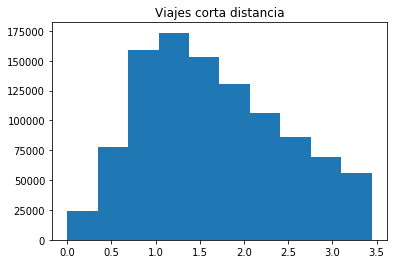

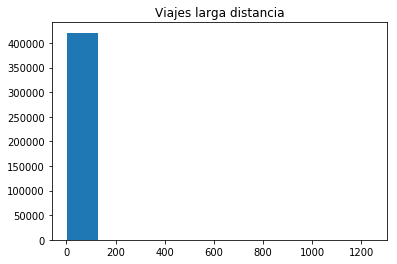

In [21]:
plt.figure()
plt.title("Viajes corta distancia")
plt.hist(data_1["distancia_viaje_km"])

plt.figure()
plt.title("Viajes larga distancia")
plt.hist(data_2["distancia_viaje_km"])
plt.show()

A primera vista, el modelo utilizado anteriormente (decision tree) pareciera ser mejor para predecir viajes de larga duración, se mantendra ese modelo para estos viajes. Ahora se probarán otros modelos para los viajes cortos:
Primero para comparar con otros modelos se verá si alguno supera al arbol de desición con parámetros base:

In [17]:
scaler.fit(X_train_1)
X_train_1_scaled = scaler.transform(X_train_1)
X_test_1_scaled = scaler.transform(X_test_1)
model = DecisionTreeRegressor()
model.fit(X_train_1_scaled,y_train_1)
print("ERROR RMSLE de test en viajes cortos: " + str(rmsle(model.predict(X_test_1_scaled),y_test_1)))

ERROR RMSLE de test en viajes cortos: 0.5544328491777335


In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(4, input_dim=13, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train_1_scaled,y_train_1)
print("ERROR RMSLE de test en viajes cortos: " + str(rmsle(model.predict(X_test_1_scaled),y_test_1)))

Epoch 1/1
723858/723858 [==============================] - 25s 35us/step - loss: 372434.4974
ERROR RMSLE de test en viajes cortos: [0.53150096]


In [21]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_jobs = 2)
model.fit(X_train_1_scaled,y_train_1)
print("ERROR RMSLE de test en viajes cortos: " + str(rmsle(model.predict(X_test_1_scaled),y_test_1)))

ERROR RMSLE de test en viajes cortos: 0.4726620002507184


Entonces se variarán los parámetros de K neighbors para ver si puede superar al arbol de decisión:

In [27]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=42)
print(X_train_1.shape)
print(y_train_1.shape)
print(X_val_1.shape)
print(y_val_1.shape)
print(X_test_1.shape)
print(y_test_1.shape)

(579086, 13)
(579086,)
(144772, 13)
(144772,)
(310226, 13)
(310226,)


In [29]:
scaler.fit(X_train_1)
X_train_1_scaled = scaler.transform(X_train_1)
X_val_1_scaled = scaler.transform(X_val_1)
X_test_1_scaled = scaler.transform(X_test_1)

In [41]:
neighbors = 13
model = KNeighborsRegressor(n_neighbors = neighbors, n_jobs = 4)
model.fit(X_train_1_scaled,y_train_1)
print("ERROR RMSLE de validación en viajes cortos: " + str(rmsle(model.predict(X_val_1_scaled),y_val_1)))

NameError: name 'KNeighborsRegressor' is not defined

n = 6: 0.46612133424421404  
n = 8: 0.46338112592233693  
n = 10: 0.46170006482016  
n = 11: 0.4611431683019462  
n = 12:0.4613014911222129  
n = 13: 0.46125195152263115  
n = 15: 0.46172889157071606  
n = 15, leaf = 40: 0.46172889157071606  
n = 20: 0.46261800108575724  

Variando el numero de vecinos no se puede mejorar lo que entrega el arbol de decisión, por lo tanto se probará una combinación de parámetros diferente del arbol de decision:

In [42]:
from ipywidgets import interactive
def interactive_Tree(depth,split):
    model = DecisionTreeRegressor(max_depth = depth, min_samples_split = split)
    model.fit(X_train_1_scaled,y_train_1)
    print("ERROR RMSLE de training: " + str(rmsle(model.predict(X_train_1_scaled),y_train_1)))
    print("ERROR RMSLE de validation: " + str(rmsle(model.predict(X_val_1_scaled),y_val_1)))

d_min = 1
d_max = 30
s_min = 2
s_max = 30
interactive(interactive_Tree,depth=(d_min,d_max),split=(s_min,s_max))

interactive(children=(IntSlider(value=15, description='depth', max=30, min=1), IntSlider(value=16, description…

Variando los parámetros del arbol de decisión no mejora los resultados.

In [29]:
from sklearn.naive_bayes import GaussianNB
scaler.fit(X_train_1)
X_train_1_scaled = scaler.transform(X_train_1)
X_val_1_scaled = scaler.transform(X_val_1)
X_test_1_scaled = scaler.transform(X_test_1)
model = GaussianNB()
model.fit(X_train_1_scaled,y_train_1)
print("ERROR RMSLE de training: " + str(rmsle(model.predict(X_train_1_scaled),y_train_1)))
print("ERROR RMSLE de validation: " + str(rmsle(model.predict(X_val_1_scaled),y_val_1)))

ERROR RMSLE de training: 1.6385927995956766
ERROR RMSLE de validation: 1.6361323409035693


Naive Bayes gaussiano tampoco mejora los resultados, además demora mucho en su ejecución.

Al probar con una serie de clasificadores y parametros para viajes cortos, se obtiene que el mejor clasificador es el arbol de clasificación con parámetros modificados para viajes cortos y largos, el clasificador que mas se le acerco en viajes cortos fue el knn con parámetros modificados, sin embargo probando con diferente cantidad de capas y neuronas debería ser posible obtener mejores resultados.